In [19]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

my_seed = 6422
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

In [20]:
tf.config.list_physical_devices('GPU')

[]

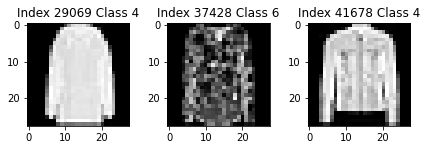

In [21]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

# Important
* Always have a validation set, the procedure to create validation or dev set is by performing random sample without replacement on train set and then only using that fraction as dev set. 
* Simple approach is to set some K samples, you can extract them from start, mid or end.
* Imagine validation set that partially approximates test set distribution and we assume our model would produce identical results when we test it on test set.
* Always optimize your hyperparameters by looking at performance on validation set and not test set.
* Do not touch test set, we have this to test how our model would work on unseen data.

In [22]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


# Points to remember
* If using any type of neural network, normalize your input between 0-1.
* One can use various procedures to achieve this, divide by largest value (for images we use 255), subtract mean from data and then normalize, one can even augment them and use other steps for normalization.
* Normalization is important step, one could observe significant boost in performance just by having better normalization scheme.
* For targets we always use one-hot encodings.

In [23]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [24]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


# Importance of weight initialization

* One reason backprop based models can perform bettter lies with the weight initialization method, one important point one should remember is that, if yur weights are initialized to be too high or low, backprop would struggle.
* Hence one should always carefully initialize weights of your model, below i have shown approach with random_normal, one can use random_uniform, truncated version of both, Xavier init and orthogonal. 
* You will find modern day NNs have achieved stable and better performance by simply switching to better init and majority of cases Xavier or Orthogonal works best.
* Always initialize your bias using zero or some small constant (ideally 0.01 or less works better). We use bias to shift the activation and in some cases it can stabalize learning, but having large bias can cause negative results.

# Loss function

* We will always cross-entropy loss for classification.

* tf softmax,
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf)), this function is simply saying that it will calculate softmax for you, simply provide logits to it. 

* In other output of your forward pass directly goes this function. Now this operator will calculate or apply softmax over prediction or logits and calculate cross-entropy between prediction and target. I am using reduce_mean since we apply this over batches.
* Second is using keras
Method 1 :- This function requires logits, hence same as above you will pass logits or output variable to this function. Now remember you need from_logits = True, for this to work.
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss_x = cce(y_true_tf, y_pred_tf) 

* Method 2:- In this we will apply softmax to output function and then pass to CCE loss.
So the approach is 
output = tf.nn.softmax(output)
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss_x = cce(y_true_tf, y_pred_tf) 

In [25]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    

    # Define the variables required for batch normalization
    # gamma, beta and epsilon

    self.gamma1 = tf.Variable(tf.ones([1, self.size_hidden1]))
    self.beta1 = tf.Variable(tf.zeros([1, self.size_hidden1]))

    self.gamma2 = tf.Variable(tf.ones([1, self.size_hidden2]))
    self.beta2 = tf.Variable(tf.zeros([1, self.size_hidden2]))

    self.gamma3 = tf.Variable(tf.ones([1, self.size_hidden3]))
    self.beta3 = tf.Variable(tf.zeros([1, self.size_hidden3]))

    self.eps = 0.001
    
    self.mean1 = tf.Variable(tf.ones([1, self.size_hidden1]))
    self.var1 = tf.Variable(tf.ones([1, self.size_hidden1]))

    self.mean2 = tf.Variable(tf.ones([1, self.size_hidden2]))
    self.var2 = tf.Variable(tf.ones([1, self.size_hidden2]))

    self.mean3 = tf.Variable(tf.ones([1, self.size_hidden3]))
    self.var3 = tf.Variable(tf.ones([1, self.size_hidden3]))

    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4, self.gamma1, self.beta1, self.gamma2, self.beta2, self.gamma3, self.beta3 ]
  
 def forward(self, X, is_training=True):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X, is_training)
    else:
      self.y = self.compute_output(X, is_training)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
           
 def batch_norm(self, h, gamma, beta, eps, is_training, mean, var):
    # If not training then don't calculate the mean and variance for individual batches
    # Use the already calculated mean and variance.

    if is_training:
      mean = tf.math.reduce_mean(h, 0)
      var = tf.math.reduce_variance(h, 0)
    #else:
      #print("USING OVERALL MEAN AND VARIANCE")
    h = gamma * ( (h - mean)/tf.math.sqrt(var + eps) )  + beta
    return h

 def calc_mean_var(self, X):
    X_tf = tf.cast(X, dtype=tf.float32)

    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    self.mean1 = tf.math.reduce_mean(h1, 0)
    self.var1 = tf.math.reduce_variance(h1, 0)+ self.eps
    h1 = ( self.gamma1*(h1-self.mean1)/tf.math.sqrt(self.var1) ) + self.beta1

    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    self.mean2 = tf.math.reduce_mean(h2, 0)
    self.var2 = tf.math.reduce_variance(h2, 0)+ self.eps
    h2 = (self.gamma2*(h2-self.mean2)/tf.math.sqrt(self.var2)) + self.beta2
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)
    self.mean3 = tf.math.reduce_mean(h3, 0)
    self.var3 = tf.math.reduce_variance(h3, 0)+ self.eps

 def compute_output(self, X, is_training=True):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers

    # ***************************
    # UNCOMMENT the block below for
    # WITH POST_ACTIVATION BATCH NORMALIZATION
    """
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    h1 = self.batch_norm(z1, self.gamma1, self.beta1, self.eps, is_training, self.mean1, self.var1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    h2 = self.batch_norm(z2, self.gamma2, self.beta2, self.eps, is_training, self.mean2, self.var2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)
    h3 = self.batch_norm(z3, self.gamma3, self.beta3, self.eps, is_training, self.mean3, self.var3)
    """
    # ***************************
    # UNCOMMENT the block below for
    # WITH PRE_ACTIVATION BATCH NORMALIZATION
    
    
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = self.batch_norm(z1, self.gamma1, self.beta1, self.eps, is_training, self.mean1, self.var1)
    h1 = tf.nn.relu(h1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = self.batch_norm(z2, self.gamma2, self.beta2, self.eps, is_training, self.mean2, self.var2)
    h2 = tf.nn.relu(h2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = self.batch_norm(z3, self.gamma3, self.beta3, self.eps, is_training, self.mean3, self.var3)
    h3 = tf.nn.relu(h3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)

#  def stderr(self,y_pred):
#     """
#      Calculate standard error
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     std_err = std_dev/sqrt(len(y_pred_tf))
#     return std_err 


#  def var(self,y_pred):
#     """
#      Calculate variance 
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     variance = (std_dev**2) # calculate variance
#     return variance 




Train Accuracy: 0.8587
Number of Epoch = 1 - Average Cross Entropy:= 0.004383536682128906 

Validation Accuracy: 0.8474

Train Accuracy: 0.8770
Number of Epoch = 2 - Average Cross Entropy:= 0.003004381408691406 

Validation Accuracy: 0.8581

Train Accuracy: 0.8898
Number of Epoch = 3 - Average Cross Entropy:= 0.0026289593505859376 

Validation Accuracy: 0.8661

Train Accuracy: 0.8978
Number of Epoch = 4 - Average Cross Entropy:= 0.002389852447509766 

Validation Accuracy: 0.8671

Train Accuracy: 0.9043
Number of Epoch = 5 - Average Cross Entropy:= 0.002200805206298828 

Validation Accuracy: 0.8697

Train Accuracy: 0.9147
Number of Epoch = 6 - Average Cross Entropy:= 0.0020453572082519533 

Validation Accuracy: 0.8730

Train Accuracy: 0.9180
Number of Epoch = 7 - Average Cross Entropy:= 0.0019110621643066406 

Validation Accuracy: 0.8723

Train Accuracy: 0.9241
Number of Epoch = 8 - Average Cross Entropy:= 0.0017683990478515625 

Validation Accuracy: 0.8742

Train Accuracy: 0.9255
Numb

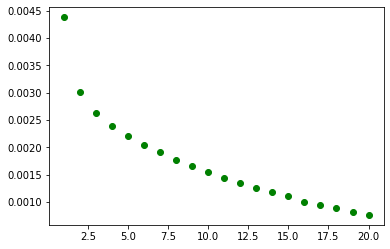

In [26]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(my_seed)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))
  mlp_on_cpu.calc_mean_var(X_train)
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [27]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs, is_training=False)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test, is_training=False)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.4134

Test Accuracy: 0.87
